<a href="https://colab.research.google.com/github/ayyucedemirbas/multi_omics_BRCA_TCGA/blob/main/BRCA_TCGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
class GraphNeuralLayer(layers.Layer):
    def __init__(self, units, activation='relu', use_bias=True, **kwargs):
        super(GraphNeuralLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias

    def build(self, input_shape):
        # input_shape: [(batch, nodes, features), (batch, nodes, nodes)]
        feature_dim = input_shape[0][-1]

        # Message passing weights
        self.W_msg = self.add_weight(
            name='W_msg',
            shape=(feature_dim, self.units),
            initializer='glorot_uniform',
            trainable=True
        )

        # Self-connection weights
        self.W_self = self.add_weight(
            name='W_self',
            shape=(feature_dim, self.units),
            initializer='glorot_uniform',
            trainable=True
        )

        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.units,),
                initializer='zeros',
                trainable=True
            )

        super(GraphNeuralLayer, self).build(input_shape)

    def call(self, inputs):
        features, adjacency = inputs

        # Self-connection: process own features
        self_output = tf.matmul(features, self.W_self)

        # Message passing: aggregate neighbor information
        neighbor_messages = tf.matmul(features, self.W_msg)
        aggregated = tf.matmul(adjacency, neighbor_messages)

        # Combine self and neighbor information
        output = self_output + aggregated

        if self.use_bias:
            output = tf.nn.bias_add(output, self.bias)

        return self.activation(output)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias
        }
        base_config = super(GraphNeuralLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
def load_and_preprocess_data():
    try:
        df = pd.read_csv('data.csv')
        print(f"Shape: {df.shape}")

        print(f"Missing values per column: {df.isnull().sum().sum()}")
        if df.isnull().sum().sum() > 0:
            # Fill missing values with median for numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
            print("Missing values filled with median")

        unique_values = df['vital.status'].unique()
        print(f"Unique vital.status values: {unique_values}")

        if set(unique_values).issubset({0, 1}):
            pass  # Already binary
        elif set(unique_values).issubset({'Alive', 'Dead', 'alive', 'dead'}):
            df['vital.status'] = df['vital.status'].str.lower().map({'alive': 0, 'dead': 1})
        elif set(unique_values).issubset({'Living', 'Deceased', 'living', 'deceased'}):
            df['vital.status'] = df['vital.status'].str.lower().map({'living': 0, 'deceased': 1})
        else:
            le = LabelEncoder()
            df['vital.status'] = le.fit_transform(df['vital_status'])
            print(f"Label encoding applied: {dict(zip(le.classes_, le.transform(le.classes_)))}")

        # Check initial label distribution
        print("Initial label distribution:")
        label_counts = df["vital.status"].value_counts()
        print(label_counts)

        # Apply upsampling like in the second project
        df_majority = df[df["vital.status"] == 0]
        df_minority = df[df["vital.status"] == 1]

        # Upsample minority class
        df_minority_upsampled = resample(df_minority,
                                         replace=True,
                                         n_samples=len(df_majority),
                                         random_state=42)

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_majority, df_minority_upsampled])

        # Verify the new distribution
        print("After upsampling:")
        label_counts_upsampled = df_balanced["vital.status"].value_counts()
        print(label_counts_upsampled)

        # Separate feature types
        rna_cols = [col for col in df_balanced.columns if col.startswith('rs_')]
        cn_cols = [col for col in df_balanced.columns if col.startswith('cn_')]
        mu_cols = [col for col in df_balanced.columns if col.startswith('mu_')]
        pp_cols = [col for col in df_balanced.columns if col.startswith('pp_')]

        print(f"Feature distribution:")
        print(f"  RNA-seq (rs_): {len(rna_cols)}")
        print(f"  Copy Number (cn_): {len(cn_cols)}")
        print(f"  Mutation (mu_): {len(mu_cols)}")
        print(f"  Protein (pp_): {len(pp_cols)}")

        return df_balanced

    except FileNotFoundError:
        print("Error: data.csv file not found.")
        return None
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

df = load_and_preprocess_data()

Shape: (705, 1937)
Missing values per column: 0
Unique vital.status values: [0 1]
Initial label distribution:
vital.status
0    611
1     94
Name: count, dtype: int64
After upsampling:
vital.status
0    611
1    611
Name: count, dtype: int64
Feature distribution:
  RNA-seq (rs_): 604
  Copy Number (cn_): 860
  Mutation (mu_): 249
  Protein (pp_): 223


In [4]:
def create_adjacency_matrix(X, method='correlation', threshold=0.7, k_neighbors=10, max_features=200):
    # Reduce feature space to prevent memory issues
    if X.shape[1] > max_features:
        print(f"Reducing features from {X.shape[1]} to {max_features} using variance selection...")
        from sklearn.feature_selection import VarianceThreshold
        selector = VarianceThreshold(threshold=0.01)
        X_reduced = selector.fit_transform(X)

        if X_reduced.shape[1] > max_features:
            # Just take top variance features
            variances = np.var(X, axis=0)
            top_indices = np.argsort(variances)[-max_features:]
            X_reduced = X[:, top_indices]
            feature_indices = top_indices
        else:
            feature_indices = np.arange(X_reduced.shape[1])

        print(f"Final feature count: {X_reduced.shape[1]}")
    else:
        X_reduced = X
        feature_indices = np.arange(X.shape[1])

    n_features = X_reduced.shape[1]

    if method == 'correlation':
        corr_matrix = np.corrcoef(X_reduced.T)
        corr_matrix = np.nan_to_num(corr_matrix, nan=0.0)
        adj_matrix = (np.abs(corr_matrix) > threshold).astype(np.float32)

    else:  # knn method
        from sklearn.neighbors import kneighbors_graph
        adj_matrix = kneighbors_graph(X_reduced.T, n_neighbors=min(k_neighbors, n_features//4),
                                    mode='connectivity', include_self=False)
        adj_matrix = adj_matrix.toarray().astype(np.float32)
        adj_matrix = (adj_matrix + adj_matrix.T) / 2

    adj_matrix += np.eye(n_features, dtype=np.float32)

    degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
    degree_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(degree_matrix) + 1e-6))
    adj_normalized = degree_inv_sqrt @ adj_matrix @ degree_inv_sqrt

    print(f"Adjacency matrix shape: {adj_normalized.shape}")
    print(f"Number of edges: {np.sum(adj_matrix > 0) // 2}")

    return adj_normalized.astype(np.float32), X_reduced.astype(np.float32), feature_indices

In [5]:
def visualize_data(df, adj_matrix):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    axes[0, 0].pie(df['vital.status'].value_counts(),
                   labels=['Alive', 'Deceased'], autopct='%1.1f%%')
    axes[0, 0].set_title('Class Distribution')

    # Feature type distributions
    rna_cols = [col for col in df.columns if col.startswith('rs_')]
    cn_cols = [col for col in df.columns if col.startswith('cn_')]
    mu_cols = [col for col in df.columns if col.startswith('mu_')]
    pp_cols = [col for col in df.columns if col.startswith('pp_')]

    feature_counts = [len(rna_cols), len(cn_cols), len(mu_cols), len(pp_cols)]
    axes[0, 1].bar(['RNA-seq', 'Copy Number', 'Mutation', 'Protein'], feature_counts)
    axes[0, 1].set_title('Feature Types Distribution')
    axes[0, 1].set_ylabel('Number of Features')

    # Sample feature distributions by class
    if len(rna_cols) > 0:
        sample_features = df[rna_cols[:10]].values
        axes[0, 2].boxplot([sample_features[df['vital.status'] == 0].flatten(),
                            sample_features[df['vital.status'] == 1].flatten()],
                           labels=['Alive', 'Deceased'])
        axes[0, 2].set_title('Sample RNA-seq Features by Class')
        axes[0, 2].set_ylabel('Expression Level')
    else:
        axes[0, 2].text(0.5, 0.5, 'No RNA-seq features found', ha='center', va='center')

    # Adjacency matrix heatmap
    sample_adj = adj_matrix[:50, :50]  # Show subset for visibility
    sns.heatmap(sample_adj, cmap='viridis', ax=axes[1, 0])
    axes[1, 0].set_title('Adjacency Matrix (50x50 subset)')

    # Degree distribution
    degrees = np.sum(adj_matrix > 0, axis=1)
    axes[1, 1].hist(degrees, bins=30, alpha=0.7)
    axes[1, 1].set_title('Node Degree Distribution')
    axes[1, 1].set_xlabel('Degree')
    axes[1, 1].set_ylabel('Frequency')

    # PCA visualization
    features = df.drop('vital.status', axis=1).values
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)

    colors = ['blue' if x == 0 else 'red' for x in df['vital.status']]
    axes[1, 2].scatter(features_pca[:, 0], features_pca[:, 1], c=colors, alpha=0.6)
    axes[1, 2].set_title(f'PCA Visualization\n(Explained variance: {pca.explained_variance_ratio_.sum():.3f})')
    axes[1, 2].set_xlabel('First Principal Component')
    axes[1, 2].set_ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()


In [6]:
def build_gnn_model(n_features, num_classes=2):
    feature_input = keras.Input(shape=(n_features, 1), name='features')
    adjacency_input = keras.Input(shape=(n_features, n_features), name='adjacency')

    x = GraphNeuralLayer(512, activation='relu')([feature_input, adjacency_input])
    x = layers.Dropout(0.2)(x)

    x = GraphNeuralLayer(128, activation='relu')([x, adjacency_input])
    x = layers.Dropout(0.2)(x)

    x = GraphNeuralLayer(64, activation='relu')([x, adjacency_input])
    x = layers.Dropout(0.2)(x)

    x = layers.GlobalAveragePooling1D()(x)

    outputs = layers.Dense(1, activation='sigmoid', name='predictions')(x)

    model = keras.Model(inputs=[feature_input, adjacency_input], outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [7]:
def prepare_graph_data(X, adj_matrix):
    # Reshape features to [batch, nodes, features]
    X_graph = X.reshape(X.shape[0], X.shape[1], 1)

    # Prepare adjacency matrix for each sample in batch
    batch_size = X.shape[0]
    adj_batch = np.tile(adj_matrix[np.newaxis, :, :], (batch_size, 1, 1))

    return X_graph, adj_batch

In [8]:
def train_and_evaluate_model(model, X_train, X_test, adj_matrix, y_train, y_test):
    X_train_graph, adj_train_batch = prepare_graph_data(X_train, adj_matrix)
    X_test_graph, adj_test_batch = prepare_graph_data(X_test, adj_matrix)

    print(f"Training data shape: {X_train_graph.shape}")
    print(f"Adjacency batch shape: {adj_train_batch.shape}")

    callbacks = [
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5),
        keras.callbacks.ModelCheckpoint('bestmodel.h5', save_best_only=True)
    ]

    history = model.fit(
        [X_train_graph, adj_train_batch],
        y_train,
        batch_size=16,
        epochs=100,
        validation_data=([X_test_graph, adj_test_batch], y_test),
        callbacks=callbacks,
        verbose=1
    )

    test_loss, test_accuracy = model.evaluate([X_test_graph, adj_test_batch], y_test, verbose=0)
    print(f"GNN Accuracy: {test_accuracy:.4f}")

    y_pred_proba = model.predict([X_test_graph, adj_test_batch])
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC Score: {auc_score:.4f}")

    return model, history, y_pred_proba, y_pred

In [9]:
def evaluate_model(model, X_test_graph, adj_test_batch, y_test):
    y_pred_proba = model.predict([X_test_graph, adj_test_batch])
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy

In [10]:
def plot_results(history, y_test, y_pred_proba, y_pred):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Training history plots
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Alive', 'Deceased'],
                yticklabels=['Alive', 'Deceased'],
                ax=axes[1, 0])
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    axes[1, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [11]:
def analyze_feature_importance(model, feature_names, X_test_graph, adj_test_batch, feature_indices):
    sample_features = tf.constant(X_test_graph[:1], dtype=tf.float32)
    sample_adj = tf.constant(adj_test_batch[:1], dtype=tf.float32)

    # Compute gradients
    with tf.GradientTape() as tape:
        sample_features_var = tf.Variable(sample_features)
        tape.watch(sample_features_var)
        predictions = model([sample_features_var, sample_adj])

    gradients = tape.gradient(predictions, sample_features_var)

    # Feature importance as absolute gradient values
    feature_importance = np.abs(gradients.numpy()).mean(axis=0).flatten()

    # Map back to original feature names using feature_indices
    original_feature_names = [feature_names[i] for i in feature_indices]

    # Top 20 most important features
    top_indices = np.argsort(feature_importance)[-20:][::-1]
    top_features = [original_feature_names[i] for i in top_indices]
    top_importance = feature_importance[top_indices]

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_importance)
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Feature Importance (Absolute Gradient)')
    plt.title('Top 20 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return dict(zip(top_features, top_importance))

In [12]:
X = df.drop(columns=["vital.status"]).values.astype(np.float32)
y = df["vital.status"].values.astype(np.float32)
feature_names = df.drop(columns=["vital.status"]).columns.tolist()

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
adj_matrix, X_reduced, feature_indices = create_adjacency_matrix(
        X_scaled, method='correlation', threshold=0.3, max_features=900
    )

Reducing features from 1936 to 900 using variance selection...
Final feature count: 900
Adjacency matrix shape: (900, 900)
Number of edges: 28257


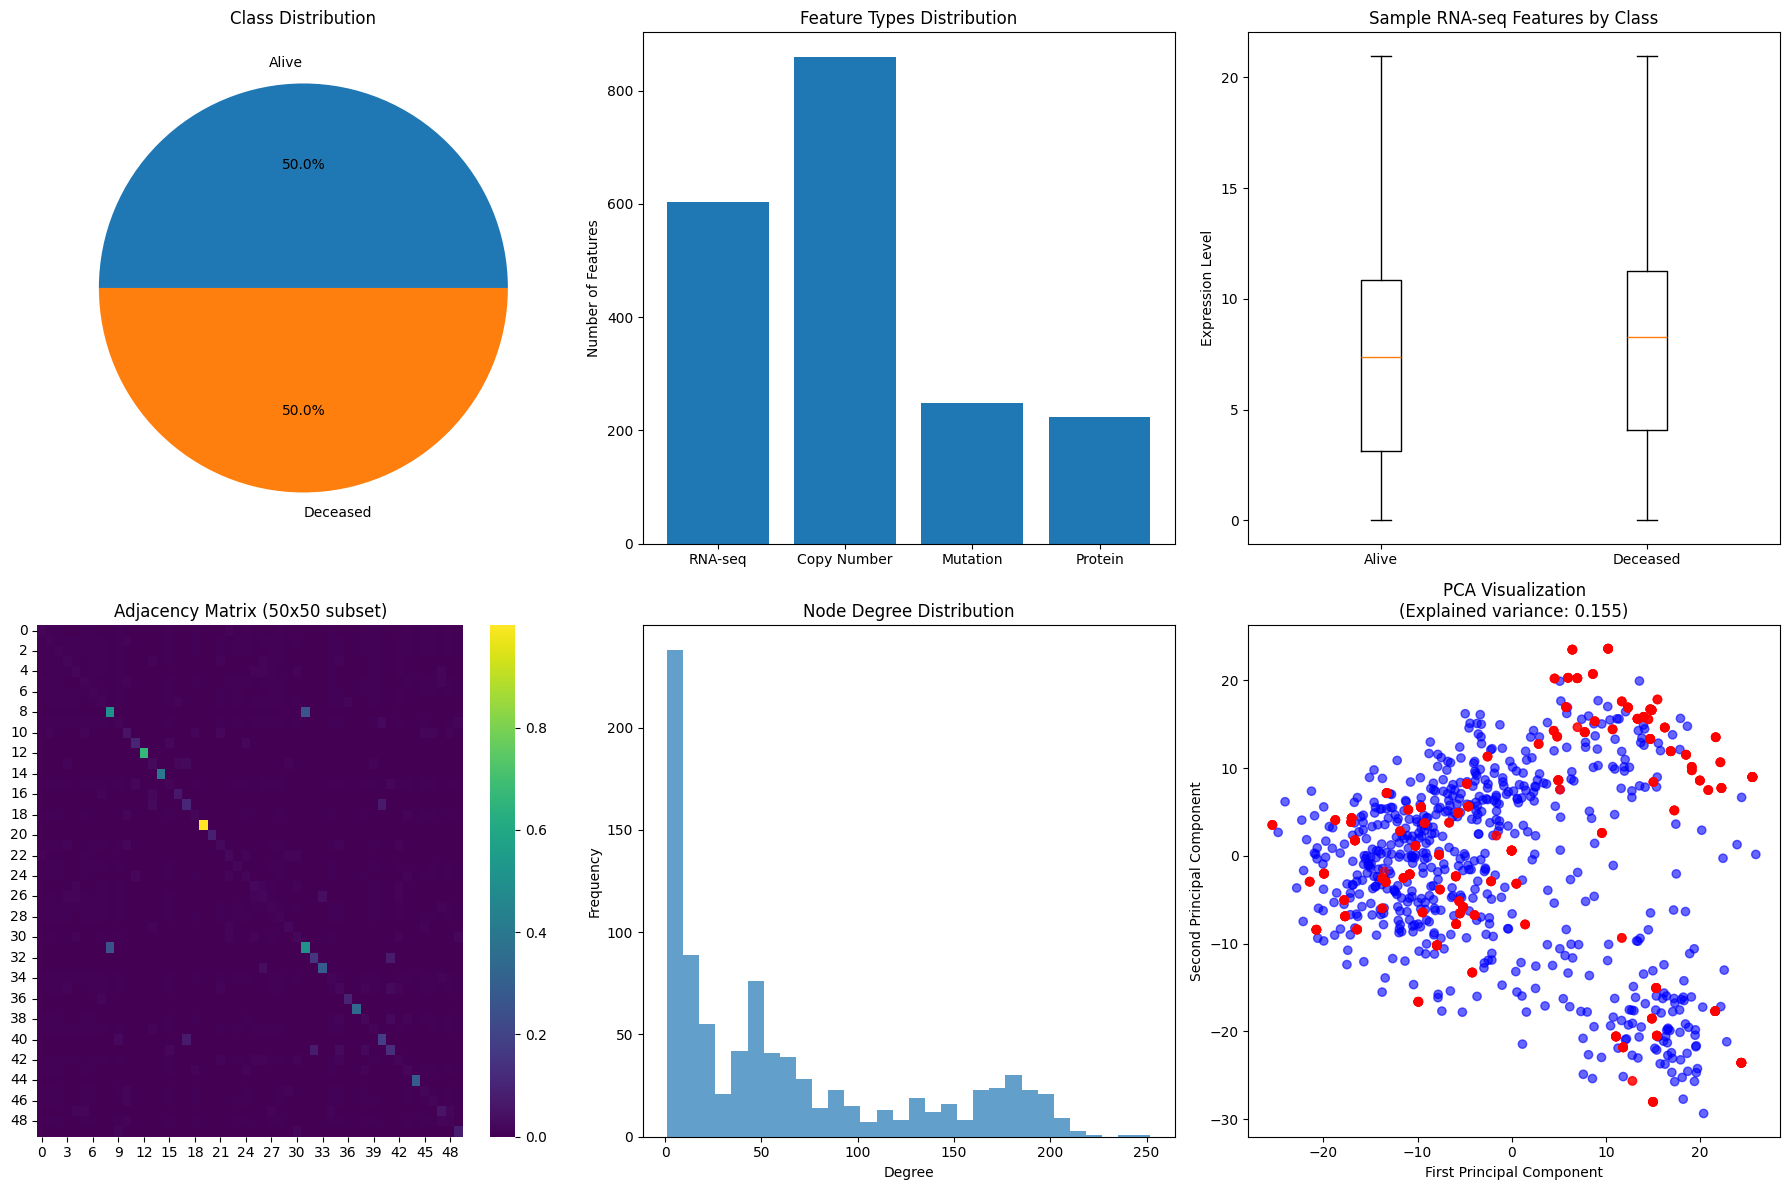

In [15]:
visualize_data(df, adj_matrix)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.2, random_state=42, stratify=y
  )

In [17]:
model = build_gnn_model(n_features=X_train.shape[1])

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 900, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjacency           │ (None, 900, 900)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_neural_layer  │ (None, 900, 512)  │      1,536 │ features[0][0],   │
│ (GraphNeuralLayer)  │                   │            │ adjacency[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 900, 512)  │          0 │ graph_neural_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_neural_layer… │ (None, 900, 128)  │    131,200 │ dropout[0][0],    │
│ (GraphNeuralLayer)  │                   │            │ adjacency[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 900, 128)  │          0 │ graph_neural_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_neural_layer… │ (None, 900, 64)   │     16,448 │ dropout_1[0][0],  │
│ (GraphNeuralLayer)  │                   │            │ adjacency[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 900, 64)   │          0 │ graph_neural_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ dropout_2[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 149,249 (583.00 KB)

 Trainable params: 149,249 (583.00 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model, history, y_pred_proba, y_pred = train_and_evaluate_model(
        model, X_train, X_test, adj_matrix, y_train, y_test
)

Training data shape: (977, 900, 1)
Adjacency batch shape: (977, 900, 900)
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.4717 - loss: 0.6978

62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 262ms/step - accuracy: 0.4720 - loss: 0.6978 - val_accuracy: 0.5673 - val_loss: 0.6872 - learning_rate: 0.0010
Epoch 2/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6049 - loss: 0.6883

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6033 - loss: 0.6884 - val_accuracy: 0.4898 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 3/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5226 - loss: 0.6885

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5232 - loss: 0.6885 - val_accuracy: 0.5102 - val_loss: 0.6755 - learning_rate: 0.0010
Epoch 4/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5176 - loss: 0.6831

62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.5185 - loss: 0.6831 - val_accuracy: 0.6082 - val_loss: 0.6703 - learning_rate: 0.0010
Epoch 5/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6148 - loss: 0.6760

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6141 - loss: 0.6762 - val_accuracy: 0.5429 - val_loss: 0.6686 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.5443 - loss: 0.6824 - val_accuracy: 0.5102 - val_loss: 0.6723 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.5474 - loss: 0.6795 - val_accuracy: 0.5184 - val_loss: 0.6700 - learning_rate: 0.0010
Epoch 8/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5970 - loss: 0.6682

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5968 - loss: 0.6685 - val_accuracy: 0.6367 - val_loss: 0.6563 - learning_rate: 0.0010
Epoch 9/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5640 - loss: 0.6711

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5647 - loss: 0.6711 - val_accuracy: 0.5755 - val_loss: 0.6533 - learning_rate: 0.0010
Epoch 10/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5817 - loss: 0.6755

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5817 - loss: 0.6755 - val_accuracy: 0.6245 - val_loss: 0.6498 - learning_rate: 0.0010
Epoch 11/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6209 - loss: 0.6600

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6197 - loss: 0.6602 - val_accuracy: 0.5878 - val_loss: 0.6468 - learning_rate: 0.0010
Epoch 12/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5881 - loss: 0.6682

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5881 - loss: 0.6681 - val_accuracy: 0.6612 - val_loss: 0.6466 - learning_rate: 0.0010
Epoch 13/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6259 - loss: 0.6557

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6252 - loss: 0.6556 - val_accuracy: 0.5429 - val_loss: 0.6438 - learning_rate: 0.0010
Epoch 14/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6115 - loss: 0.6454

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6117 - loss: 0.6457 - val_accuracy: 0.6286 - val_loss: 0.6233 - learning_rate: 0.0010
Epoch 15/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5811 - loss: 0.6536

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5813 - loss: 0.6535 - val_accuracy: 0.6000 - val_loss: 0.6208 - learning_rate: 0.0010
Epoch 16/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6158 - loss: 0.6390 - val_accuracy: 0.5918 - val_loss: 0.6229 - learning_rate: 0.0010
Epoch 17/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.6590 - loss: 0.6250 - val_accuracy: 0.5673 - val_loss: 0.6212 - learning_rate: 0.0010
Epoch 18/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6011 - loss: 0.6449

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6010 - loss: 0.6448 - val_accuracy: 0.5878 - val_loss: 0.6118 - learning_rate: 0.0010
Epoch 19/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6470 - loss: 0.6187

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6451 - loss: 0.6195 - val_accuracy: 0.6327 - val_loss: 0.6096 - learning_rate: 0.0010
Epoch 20/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.6007 - loss: 0.6209 - val_accuracy: 0.6694 - val_loss: 0.6250 - learning_rate: 0.0010
Epoch 21/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6557 - loss: 0.6284 - val_accuracy: 0.6612 - val_loss: 0.6218 - learning_rate: 0.0010
Epoch 22/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6230 - loss: 0.6516

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6229 - loss: 0.6514 - val_accuracy: 0.6286 - val_loss: 0.6020 - learning_rate: 0.0010
Epoch 23/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5872 - loss: 0.6358

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.5883 - loss: 0.6355 - val_accuracy: 0.6367 - val_loss: 0.5919 - learning_rate: 0.0010
Epoch 24/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6083 - loss: 0.6249

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6087 - loss: 0.6248 - val_accuracy: 0.6245 - val_loss: 0.5916 - learning_rate: 0.0010
Epoch 25/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6457 - loss: 0.6112 - val_accuracy: 0.6776 - val_loss: 0.6162 - learning_rate: 0.0010
Epoch 26/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6293 - loss: 0.6303 - val_accuracy: 0.6776 - val_loss: 0.6082 - learning_rate: 0.0010
Epoch 27/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6139 - loss: 0.6320

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6146 - loss: 0.6317 - val_accuracy: 0.6449 - val_loss: 0.5854 - learning_rate: 0.0010
Epoch 28/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6338 - loss: 0.6027 - val_accuracy: 0.6735 - val_loss: 0.5978 - learning_rate: 0.0010
Epoch 29/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6306 - loss: 0.6464 - val_accuracy: 0.6612 - val_loss: 0.5893 - learning_rate: 0.0010
Epoch 30/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6247 - loss: 0.6149 - val_accuracy: 0.6776 - val_loss: 0.5886 - learning_rate: 0.0010
Epoch 31/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6563 - loss: 0.5902

62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6561 - loss: 0.5905 - val_accuracy: 0.6939 - val_loss: 0.5805 - learning_rate: 0.0010
Epoch 32/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6533 - loss: 0.6186

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6529 - loss: 0.6186 - val_accuracy: 0.6490 - val_loss: 0.5667 - learning_rate: 0.0010
Epoch 33/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6180 - loss: 0.6148 - val_accuracy: 0.6571 - val_loss: 0.5718 - learning_rate: 0.0010
Epoch 34/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6630 - loss: 0.5885

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6631 - loss: 0.5885 - val_accuracy: 0.6571 - val_loss: 0.5561 - learning_rate: 0.0010
Epoch 35/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6638 - loss: 0.5828 - val_accuracy: 0.6653 - val_loss: 0.5563 - learning_rate: 0.0010
Epoch 36/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.6600 - loss: 0.6053 - val_accuracy: 0.7020 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 37/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6682 - loss: 0.5952 - val_accuracy: 0.7306 - val_loss: 0.5582 - learning_rate: 0.0010
Epoch 38/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6841 - loss: 0.5904

62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.6841 - loss: 0.5904 - val_accuracy: 0.7429 - val_loss: 0.5442 - learning_rate: 0.0010
Epoch 39/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7055 - loss: 0.5655

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7047 - loss: 0.5661 - val_accuracy: 0.6898 - val_loss: 0.5424 - learning_rate: 0.0010
Epoch 40/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7002 - loss: 0.5733 - val_accuracy: 0.6531 - val_loss: 0.5777 - learning_rate: 0.0010
Epoch 41/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6936 - loss: 0.5994 - val_accuracy: 0.6816 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 42/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7031 - loss: 0.5572

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7029 - loss: 0.5576 - val_accuracy: 0.7469 - val_loss: 0.5315 - learning_rate: 0.0010
Epoch 43/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6907 - loss: 0.5602 - val_accuracy: 0.6571 - val_loss: 0.5421 - learning_rate: 0.0010
Epoch 44/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7020 - loss: 0.5658

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7023 - loss: 0.5658 - val_accuracy: 0.6939 - val_loss: 0.5314 - learning_rate: 0.0010
Epoch 45/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6715 - loss: 0.6018 - val_accuracy: 0.7020 - val_loss: 0.5399 - learning_rate: 0.0010
Epoch 46/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7207 - loss: 0.5512

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7209 - loss: 0.5513 - val_accuracy: 0.7184 - val_loss: 0.5202 - learning_rate: 0.0010
Epoch 47/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7216 - loss: 0.5768 - val_accuracy: 0.7224 - val_loss: 0.5313 - learning_rate: 0.0010
Epoch 48/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7224 - loss: 0.5477 - val_accuracy: 0.7347 - val_loss: 0.5259 - learning_rate: 0.0010
Epoch 49/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6859 - loss: 0.5857 - val_accuracy: 0.7306 - val_loss: 0.5228 - learning_rate: 0.0010
Epoch 50/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.7049 - loss: 0.5405 - val_accuracy: 0.7102 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 51/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7439 - loss: 0.5246

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7433 - loss: 0.5253 - val_accuracy: 0.7224 - val_loss: 0.5200 - learning_rate: 0.0010
Epoch 52/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6882 - loss: 0.5638

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6888 - loss: 0.5635 - val_accuracy: 0.7429 - val_loss: 0.5139 - learning_rate: 0.0010
Epoch 53/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7262 - loss: 0.5534

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7263 - loss: 0.5527 - val_accuracy: 0.7429 - val_loss: 0.5083 - learning_rate: 0.0010
Epoch 54/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7450 - loss: 0.5542 - val_accuracy: 0.7224 - val_loss: 0.5179 - learning_rate: 0.0010
Epoch 55/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7461 - loss: 0.5317 - val_accuracy: 0.7184 - val_loss: 0.5260 - learning_rate: 0.0010
Epoch 56/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6989 - loss: 0.5830

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7003 - loss: 0.5818 - val_accuracy: 0.7265 - val_loss: 0.5078 - learning_rate: 0.0010
Epoch 57/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7180 - loss: 0.5452

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7185 - loss: 0.5445 - val_accuracy: 0.7551 - val_loss: 0.5000 - learning_rate: 0.0010
Epoch 58/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7645 - loss: 0.5132 - val_accuracy: 0.7592 - val_loss: 0.5116 - learning_rate: 0.0010
Epoch 59/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7445 - loss: 0.5297

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7444 - loss: 0.5297 - val_accuracy: 0.7633 - val_loss: 0.4972 - learning_rate: 0.0010
Epoch 60/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7367 - loss: 0.5153 - val_accuracy: 0.7061 - val_loss: 0.5207 - learning_rate: 0.0010
Epoch 61/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6803 - loss: 0.5686

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6821 - loss: 0.5672 - val_accuracy: 0.7265 - val_loss: 0.4914 - learning_rate: 0.0010
Epoch 62/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7138 - loss: 0.5789 - val_accuracy: 0.7143 - val_loss: 0.5001 - learning_rate: 0.0010
Epoch 63/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6772 - loss: 0.5826 - val_accuracy: 0.7429 - val_loss: 0.5014 - learning_rate: 0.0010
Epoch 64/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7617 - loss: 0.5248 - val_accuracy: 0.7469 - val_loss: 0.4954 - learning_rate: 0.0010
Epoch 65/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7660 - loss: 0.5221 - val_accuracy: 0.7184 - val_loss: 0.4961 - learning_rate: 0.0010
Epoch 66/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7336 - loss: 0.5295 - val_accuracy: 0.7633 - val_loss: 0.4918 - learning_rate: 0.0010
Epoch 67/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7297 - loss: 0.5177

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7297 - loss: 0.5177 - val_accuracy: 0.7796 - val_loss: 0.4902 - learning_rate: 0.0010
Epoch 68/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7269 - loss: 0.5466 - val_accuracy: 0.7429 - val_loss: 0.5130 - learning_rate: 0.0010
Epoch 69/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7128 - loss: 0.5288 - val_accuracy: 0.7061 - val_loss: 0.5334 - learning_rate: 0.0010
Epoch 70/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.7315 - loss: 0.5453 - val_accuracy: 0.7102 - val_loss: 0.5114 - learning_rate: 0.0010
Epoch 71/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7777 - loss: 0.5075 - val_accuracy: 0.6980 - val_loss: 0.5246 - learning_rate: 0.0010
Epoch 72/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7429 - loss: 0.5228 - val_accuracy: 0.6939 - val_loss: 0.5268 - learning_rate: 0.0010
Epoch 73/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.7588 - loss: 0.4972 - val_ac

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7206 - loss: 0.5344 - val_accuracy: 0.7714 - val_loss: 0.4863 - learning_rate: 0.0010
Epoch 78/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7327 - loss: 0.5117 - val_accuracy: 0.7347 - val_loss: 0.5103 - learning_rate: 0.0010
Epoch 79/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7275 - loss: 0.5251 - val_accuracy: 0.7429 - val_loss: 0.4954 - learning_rate: 0.0010
Epoch 80/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7628 - loss: 0.5150 - val_accuracy: 0.7306 - val_loss: 0.4992 - learning_rate: 0.0010
Epoch 81/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7503 - loss: 0.5105

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7505 - loss: 0.5099 - val_accuracy: 0.7633 - val_loss: 0.4760 - learning_rate: 0.0010
Epoch 82/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7522 - loss: 0.4841 - val_accuracy: 0.7469 - val_loss: 0.4821 - learning_rate: 0.0010
Epoch 83/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7715 - loss: 0.4683 - val_accuracy: 0.7592 - val_loss: 0.4809 - learning_rate: 0.0010
Epoch 84/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7818 - loss: 0.4733 - val_accuracy: 0.7551 - val_loss: 0.4869 - learning_rate: 0.0010
Epoch 85/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7731 - loss: 0.4782 - val_accuracy: 0.7551 - val_loss: 0.4897 - learning_rate: 0.0010
Epoch 86/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7594 - loss: 0.4982

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7602 - loss: 0.4978 - val_accuracy: 0.7592 - val_loss: 0.4750 - learning_rate: 0.0010
Epoch 87/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7323 - loss: 0.5389

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7331 - loss: 0.5378 - val_accuracy: 0.7959 - val_loss: 0.4697 - learning_rate: 0.0010
Epoch 88/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7544 - loss: 0.4930 - val_accuracy: 0.7755 - val_loss: 0.4750 - learning_rate: 0.0010
Epoch 89/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7419 - loss: 0.5252

62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.7427 - loss: 0.5242 - val_accuracy: 0.7755 - val_loss: 0.4689 - learning_rate: 0.0010
Epoch 90/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7851 - loss: 0.4653 - val_accuracy: 0.7673 - val_loss: 0.4830 - learning_rate: 0.0010
Epoch 91/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7446 - loss: 0.4918 - val_accuracy: 0.7224 - val_loss: 0.4997 - learning_rate: 0.0010
Epoch 92/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7367 - loss: 0.4979 - val_accuracy: 0.7592 - val_loss: 0.4741 - learning_rate: 0.0010
Epoch 93/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7896 - loss: 0.4573

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7889 - loss: 0.4581 - val_accuracy: 0.7878 - val_loss: 0.4680 - learning_rate: 0.0010
Epoch 94/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7899 - loss: 0.4617 - val_accuracy: 0.7755 - val_loss: 0.4716 - learning_rate: 0.0010
Epoch 95/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.7575 - loss: 0.4907 - val_accuracy: 0.7878 - val_loss: 0.4725 - learning_rate: 0.0010
Epoch 96/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7768 - loss: 0.4697 - val_accuracy: 0.7592 - val_loss: 0.4687 - learning_rate: 0.0010
Epoch 97/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7723 - loss: 0.4730 - val_accuracy: 0.7633 - val_loss: 0.4852 - learning_rate: 0.0010
Epoch 98/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8048 - loss: 0.4387 - val_accuracy: 0.7510 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 99/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7460 - loss: 0.4946 - val_ac

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7099 - loss: 0.5292 - val_accuracy: 0.7918 - val_loss: 0.4599 - learning_rate: 0.0010
GNN Accuracy: 0.7918
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79       123
         1.0       0.78      0.80      0.79       122

    accuracy                           0.79       245
   macro avg       0.79      0.79      0.79       245
weighted avg       0.79      0.79      0.79       245

AUC Score: 0.8691


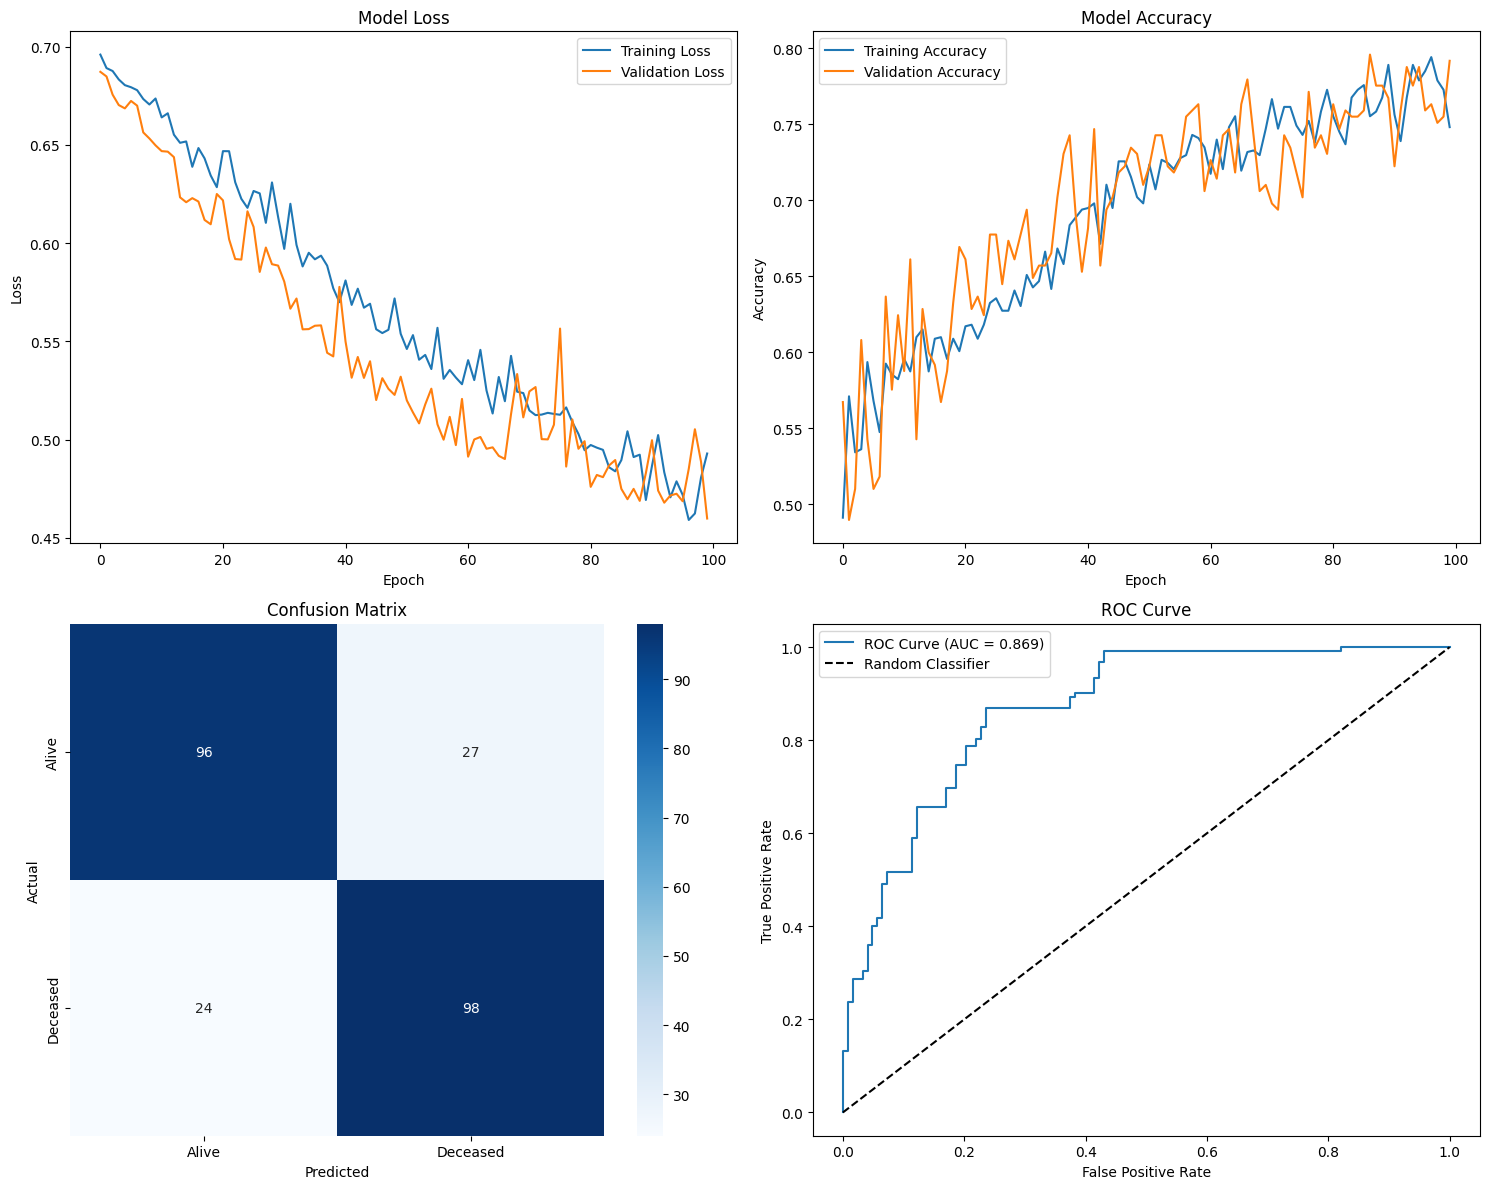

In [20]:
plot_results(history, y_test, y_pred_proba, y_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Accuracy: 0.7918
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79       123
         1.0       0.78      0.80      0.79       122

    accuracy                           0.79       245
   macro avg       0.79      0.79      0.79       245
weighted avg       0.79      0.79      0.79       245

Confusion Matrix:


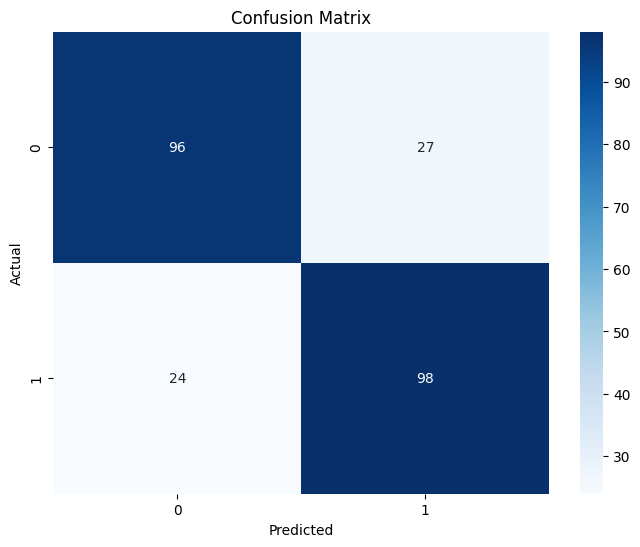

In [21]:
X_test_graph, adj_test_batch = prepare_graph_data(X_test, adj_matrix)
accuracy = evaluate_model(model, X_test_graph, adj_test_batch, y_test)

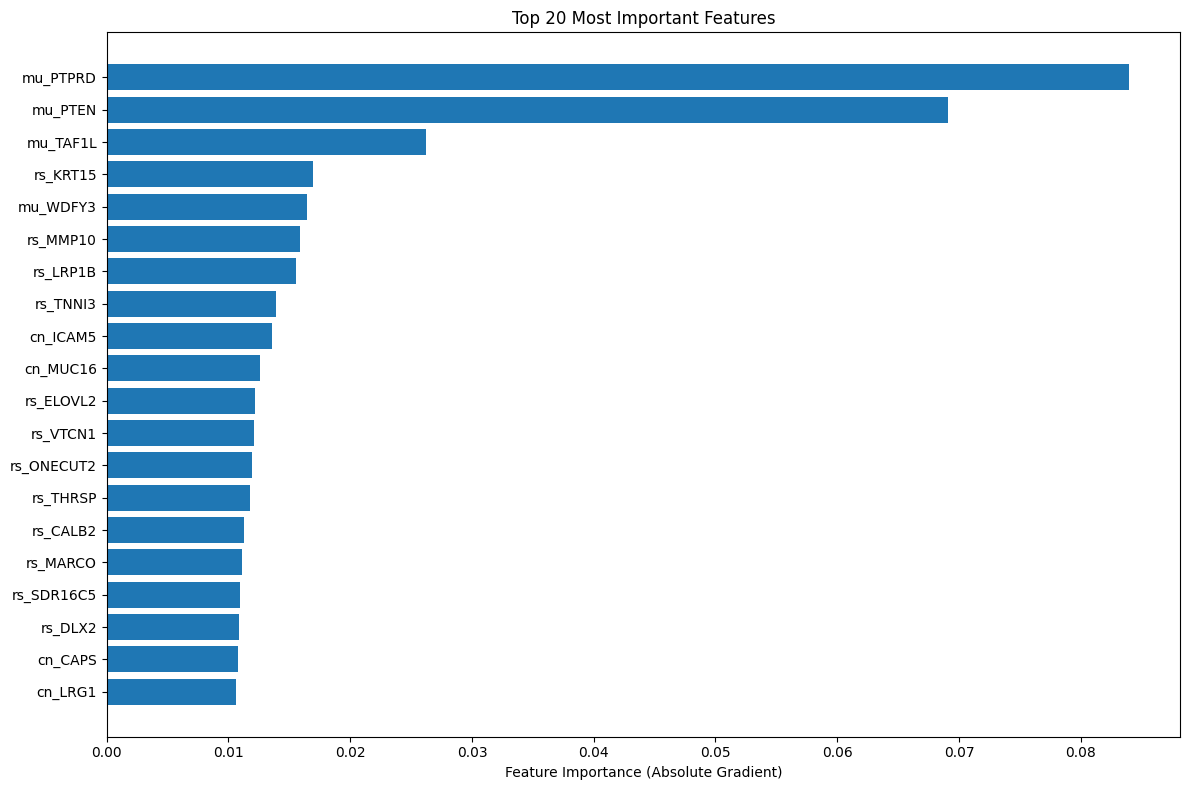

In [22]:
feature_importance = analyze_feature_importance(
        model, feature_names, X_test_graph, adj_test_batch, feature_indices
)

In [23]:
print("\nTop 10 Most Important Features:")
for i, (feature, importance) in enumerate(list(feature_importance.items())[:10]):
  print(f"{i+1:2d}. {feature:<20}: {importance:.4f}")


Top 10 Most Important Features:
 1. mu_PTPRD            : 0.0840
 2. mu_PTEN             : 0.0691
 3. mu_TAF1L            : 0.0262
 4. rs_KRT15            : 0.0170
 5. mu_WDFY3            : 0.0165
 6. rs_MMP10            : 0.0159
 7. rs_LRP1B            : 0.0156
 8. rs_TNNI3            : 0.0139
 9. cn_ICAM5            : 0.0136
10. cn_MUC16            : 0.0126
